# DermaMNIST Classification Model Training


In this notebook, we look at the HAM10000 dataset and train a resnet18 model to classify individual skin images into the seven given classes. *HAM10000 is a dataset of 10000 training images for the detection of pigmented skin lesions. The authors collected dermoscopic images from different population groups, which were acquired and stored using different modalities.*

Since training the model can take some time, depending on the available computing power, a pre-trained model is also provided in this directory.

First, let's import the required Python libraries. Make sure you have installed the packages before using the requirements file in the root folder.

In [3]:
import numpy as np
import tqdm

import medmnist
from torchvision import transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.optim as optim

import matplotlib.pyplot as plt

## **Data Preparation**

To load the data set, we use the medmnist library, which contains standardized images datasets for various medical topics. In this tutorial, we will focus on the dermamnist (HAM10000) dataset.

In [5]:
# specify dataset
data_flag = 'dermamnist'

# get information about the dataset
info = medmnist.INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

Let's have a look the information panel:

In [7]:
info

{'python_class': 'DermaMNIST',
 'description': 'The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/dermamnist.npz?download=1',
 'MD5': '0744692d530f8e62ec473284d019b0c7',
 'url_64': 'https://zenodo.org/records/10519652/files/dermamnist_64.npz?download=1',
 'MD5_64': 'b70a2f5635c6199aeaa28c31d7202e1f',
 'url_128': 'https://zenodo.org/records/10519652/files/dermamnist_128.npz?download=1',
 'MD5_128': '2defd784463fa5243564e855ed717de1',
 'url_224': 'https://zenodo.org/records/10519652/files/dermamnist_224.npz?download=1',
 'MD5_224': '8974907d8e169bef5f5b96bc506ae45d',
 'task': 'multi-c

As the last step in data preparation, we load data and normalize it.

In [9]:
mean = 0.5
std = 0.5 

# preprocessing transforms
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, size=64, download=True)
val_dataset = DataClass(split='val', transform=data_transform, size=64, download=True)

Let's visualize some samples:

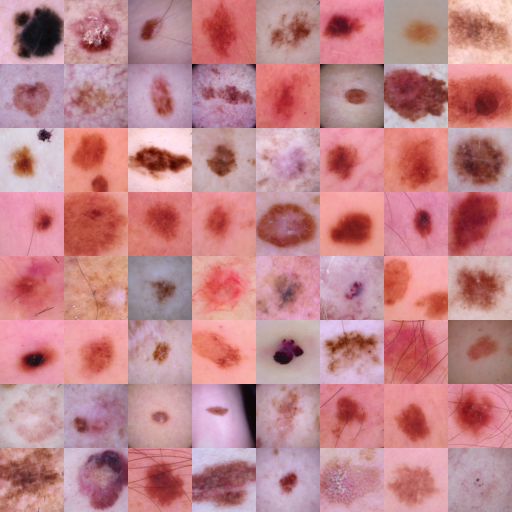

In [11]:
train_dataset.montage(length=8)

## **Model Training**

Our goal is to correctly classify pigmented skin lesions. To do so, we are training a multi-class classification model. More precisely, we use a resnet-18 model. 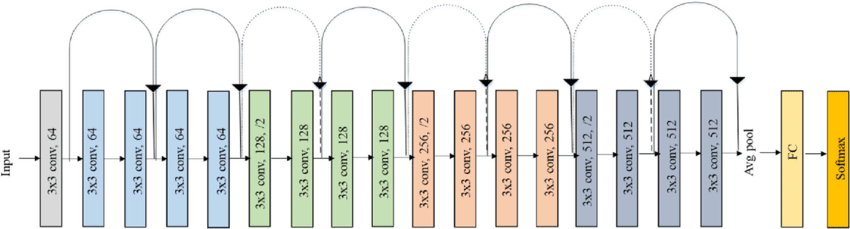

We start by setting some parameters: 

In [13]:
batch_size = 128
num_epochs = 5
learning_rate = 0.001

# path to store the best model
best_model_path = "best_dermamnist_resnet_model.pth"
# to determine the best model
best_val_acc = 0.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Then, we set up the dataloaders and define the model.

In [15]:
# data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size)

# pretrained restnet model with last layer adapted to 7 classes.
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, n_classes)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

And finally, we can train the model:

In [17]:
for epoch in tqdm.tqdm(range(num_epochs)):

    # Training
    ##################################
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.squeeze().long().to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    ##################################

    # Validation
    ##################################  
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.squeeze().long().to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    ##################################

    # Save the best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Current best accuracy: {best_val_acc}")
        print("Best model saved.")

 20%|█████████████████████▏                                                                                    | 1/5 [01:36<06:27, 96.95s/it]

Current best accuracy: 74.37686939182453
Best model saved.


 80%|████████████████████████████████████████████████████████████████████████████████████                     | 4/5 [07:10<01:52, 112.16s/it]

Current best accuracy: 77.66699900299103
Best model saved.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [09:14<00:00, 110.90s/it]

Current best accuracy: 78.5643070787637
Best model saved.


## **Validation**

As a final step, let's review a few predictions. Since the dataset is imbalanced, we will use the helper function **first_k_unique_indices** to look at the samples and predictions of the different classes.

In [19]:
def first_k_unique_indices(labels: torch.Tensor, k: int = 5):
    """Return indices of the first k distinct values in `labels`."""
    seen, idxs = set(), []
    for i, v in enumerate(labels):
        val = v.item()
        if val not in seen:
            seen.add(val)
            idxs.append(i)
            if len(idxs) == k:
                break
    return torch.tensor(idxs)

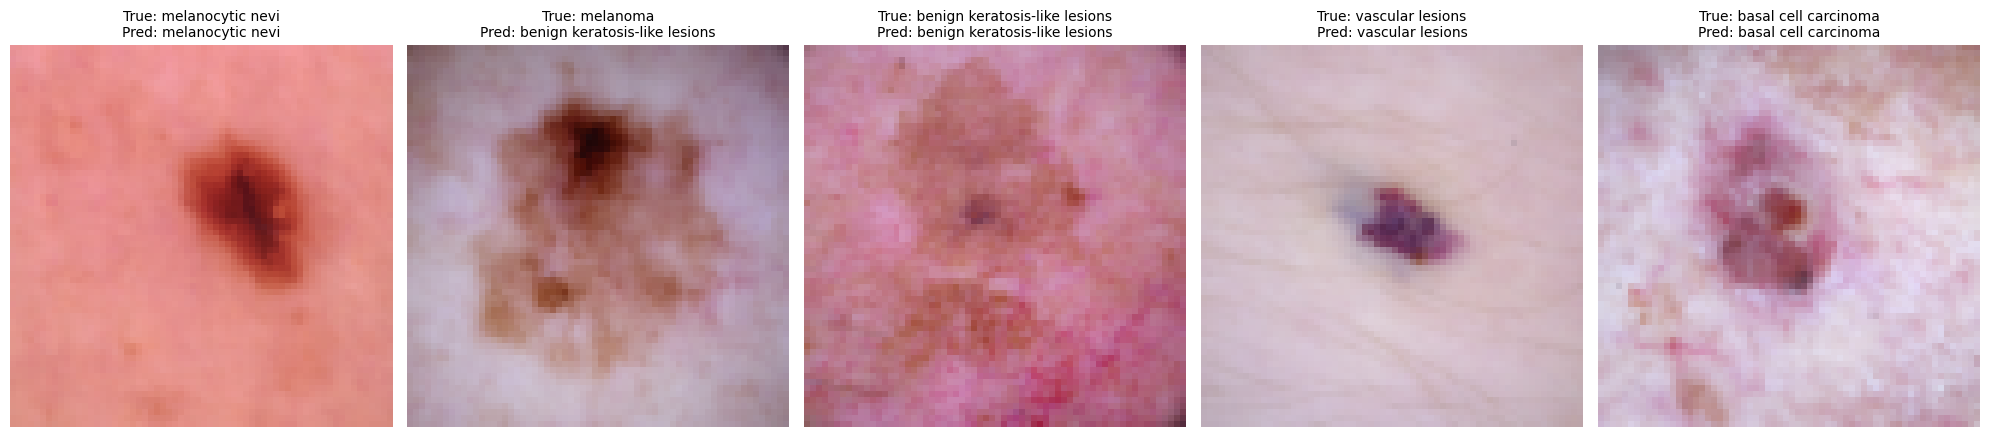

In [20]:
# get images and labels from validation set
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.squeeze().long().to(device)

# predict
outputs = model(images)
_, predicted = torch.max(outputs, 1)
sel = first_k_unique_indices(labels, k=5)

# and plot
fig, axes = plt.subplots(1, 5, figsize=(4 * 5, 6))
for ax, idx in zip(axes, sel):
    img = images[idx].cpu().numpy()
    img = (std * img + mean).clip(0, 1)    

    ax.imshow(img.transpose(1, 2, 0))
    ax.set_title(f"True: {info['label'][str(int(labels[idx]))]}\n"
                 f"Pred: {info['label'][str(int(predicted[idx]))]}",
                 fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()